<a href="https://colab.research.google.com/github/nadaabosreea/ID-Text-Detection-using-Fasterrcnn/blob/main/ID_Text_Detection_using_Fasterrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Installs & Imports

In [22]:
# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=65ed63d8436c3018a36949b6836a08ccfa8877299290be8ca8ace6533183e876
  Stored in directory: /root/.cache/pip/wheels/d2/e3/0b/99a239413035502833a7b07283894243fddf5ce3aa720ca8dd
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Cloning into 'vision'...
remote: Enumerating objects: 298319, done.
remote: Counting objects: 100% (8105/8105), done.
remote: Compressing objects: 100% (648/648), done.
remote: Total 298319 (delta 7574), reused 7910 (delta 7439), pack-reused 290214
Receiving objects: 100% (298319/298319)

In [23]:
# basic python and ML Libraries
import os
import cv2
import numpy as np 
from PIL import Image, ImageOps
import random
import pandas as pd
from tqdm import tqdm
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


# 2. Preparing the Data
## Unzip

In [ ]:
!unzip '/content/drive/MyDrive/datasets/BID Dataset.zip'

## Inspecting the Data 

> from the dataset Repo

BID Dataset was presented in work: "BID Dataset: a challenge dataset for document processing tasks", and aims at three crucial challenges in the Computer Vision field: (i) Document Images Classification; (ii) Text Region Segmentation and (iii) Optical Character Recognition (OCR). BID Dataset is composed of images of Brazilian identification documents divided into eight classes: front and back faces of National Driver's License (CNH), CNH front face, CNH back face, Natural Persons Register (CPF) front face, CPF back face, General Registration (RG) front face, RG back face, and RG front and back faces.

BID Dataset is composed of 28,800 document images, with 3,600 samples for each class.

In [ ]:
def read_image(image_path):
    pil_image = Image.open(img_path).convert('RGB')
    try:
        pil_image_transposed = ImageOps.exif_transpose(pil_image)
    except:
        return pil_image

    return np.array(pil_image_transposed)  # the output is different when we convert to array first then exif transpose

CPF_VERSO
00014698_gt_ocr.txt
x, y, width, height, transcription
135, 127, 237, 16, CARTÃO DE USO PESSOAL E INTRANSFERÍVEL
61, 145, 384, 16, DEVE SER APRESENTADO JUNTO COM UM DOCUMENTO DE IDENTIDADE
49, 253, 57, 14, EMISSÃO
41, 274, 86, 19, MAIO/2003
347, 242, 116, 27, CAIXA
348, 270, 116, 12, CAIXA ECONÔMICA FEDERAL

00014698_gt_segmentation.jpg


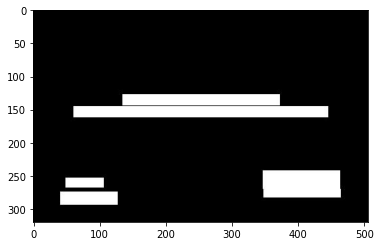

00014698_in.jpg


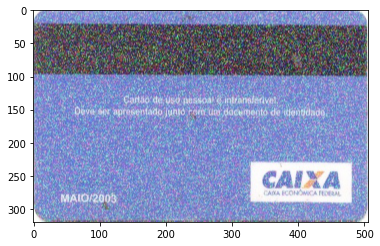

00014699_gt_ocr.txt
x, y, width, height, transcription
205, 224, 30, 444, CARTÃO DE USO PESSOAL E INTRANSFERÍVEL
235, 86, 29, 722, DEVE SER APRESENTADO JUNTO COM UM DOCUMENTO DE IDENTIDADE
406, 714, 26, 94, EMISSÃO
436, 678, 22, 129, MAI/2008
414, 46, 44, 197, CORREIOS
466, 37, 25, 302, WWW.CORREIOS.COM.BR

00014699_gt_segmentation.jpg


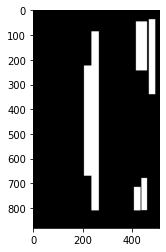

00014699_in.jpg


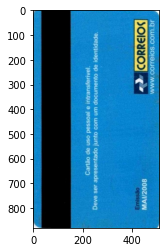

00014700_gt_ocr.txt
x, y, width, height, transcription
163, 158, 16, 212, CARTÃO DE USO PESSOAL E INTRANSFERÍVEL
147, 90, 17, 348, DEVE SER APRESENTADO JUNTO COM UM DOCUMENTO DE IDENTIDADE
45, 30, 14, 55, EMISSÃO
31, 34, 15, 65, JUN/2010
40, 374, 27, 112, CORREIOS

00014700_gt_segmentation.jpg


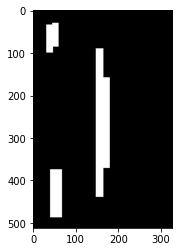

00014700_in.jpg


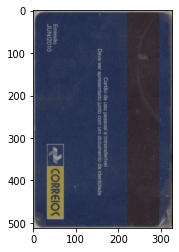

00014701_gt_ocr.txt
x, y, width, height, transcription
176, 227, 316, 19, CARTÃO DE USO PESSOAL E INTRANSFERÍVEL
75, 203, 514, 17, DEVE SER APRESENTADO JUNTO COM UM DOCUMENTO DE IDENTIDADE
537, 65, 71, 17, EMISSÃO
490, 29, 127, 20, ABRIL/2002
54, 66, 156, 37, CAIXA
50, 51, 161, 13, CAIXA ECONÔMICA FEDERAL

-----------------------------------
RG_ABERTO
00018411_gt_ocr.txt
x, y, width, height, transcription
328, 176, 23, 152, 07/10/1977
307, 76, 20, 196, DATA DE NASCIMENTO
233, 408, 23, 428, ENTINI HOLTZ SCHACHTER
160, 288, 22, 483, RAMPIN ANUNCIATO CERAVOLO
88, 357, 20, 414, GARBUI SEINO KUPERSZMIDT
467, 324, 26, 396, C.NAS=264 LV=200 FL=236
392, 570, 26, 151, ÁUREA-RS
434, 316, 25, 404, CMC= BARREIROS-PE ,SEDE
404, 746, 21, 123, DOC. ORIGEM
501, 826, 21, 41, CPF
314, 686, 29, 172, LAVÍNIA-SP
301, 732, 20, 135, NATURALIDADE
581, 343, 22, 219, ASSINATURA DO DIRETOR
39, 353, 21, 75, DATA DE
62, 325, 20, 107, EXPEDIÇÃO
41, 144, 27, 176, 11/07/1957
38, 565, 23, 173, 04.186.980-1
37, 776, 19

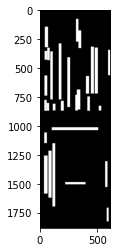

00018411_in.jpg


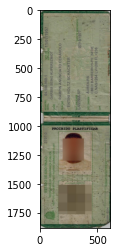

00018412_gt_ocr.txt
x, y, width, height, transcription
335, 151, 20, 141, 03/05/1993
300, 95, 22, 208, DATA DE NASCIMENTO
66, 185, 21, 141, 29/10/1978
49, 391, 23, 80, DATA DE
68, 365, 24, 107, EXPEDIÇÃO
75, 509, 19, 62, 2 VIA
71, 624, 24, 189, 97.713.879-3
54, 833, 23, 100, REGISTRO
76, 862, 19, 68, GERAL
157, 518, 19, 402, CASCIANO DARUIZ MARJORY
126, 869, 20, 61, NOME
189, 839, 26, 90, FILIAÇÃO
228, 627, 16, 296, GABRIELLI GRAAF HAUTZ
262, 600, 15, 318, CICARONE PICHI FEUERHARMEL
308, 782, 22, 147, NATURALIDADE
339, 813, 20, 106, UNA-BA
404, 799, 22, 126, DOC. ORIGEM
535, 729, 20, 188, 243.016.031-58
498, 881, 22, 46, CPF
431, 593, 23, 330, C.NAS=74 LV=71 FL=169
529, 397, 14, 148, BARCELLOS MAI
[596, 601, 579, 578], [380, 613, 613, 379], -1, -1, ASSINATURA DO DIRETOR
[625, 628, 606, 605], [377, 620, 619, 374], -1, -1, LEI Nº7.116 DE 29/08/83
[36, 42, 19, 13], [270, 734, 737, 273], -1, -1, VÁLIDA EM TODO O TERRITÓRIO NACIONAL
172, 988, 221, 27, NÃO PLASTIFICAR
66, 1092, 18, 69, 1638-

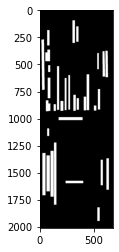

00018412_in.jpg


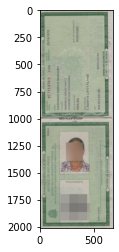

00018413_gt_ocr.txt
x, y, width, height, transcription
1073, 73, 188, 21, REGISTRO GERAL
1069, 121, 73, 23, NOME
1070, 481, 86, 21, CODÓ-MA
288, 151, 167, 20, 54.216.384-6
398, 233, 23, 184, POLEGAR DIREITO
377, 539, 229, 20, ASSINATURA DO TITULAR
345, 563, 290, 20, CARTEIRA DE IDENTIDADE
1161, 115, 355, 18, PELICARI MANZINE CANHOLI
1287, 70, 123, 16, 86.156.474-1
[1267, 1265, 1730, 1733], [26, 47, 53, 31], -1, -1, VÁLIDA EM TODO O TERRITÓRIO NACIONAL
[1560, 1560, 1782, 1780], [76, 98, 102, 77], -1, -1, DATA DE EXPEDIÇÃO
[1540, 1541, 1778, 1779], [254, 278, 279, 258], -1, -1, DATA DE NASCIMENTO
1173, 171, 170, 15, RHUDNER NESTI 
1174, 203, 294, 15, CAMBIAGHI KAGEYAMA PEZ
[216, 213, 751, 749], [81, 105, 111, 84], -1, -1, SECRETARIA DE ESTADO DA SEGURANÇA PÚBLICA
[256, 257, 708, 708], [112, 134, 135, 111], -1, -1, INSTITUTO DE IDENTIFICAÇÃO DO PARANÁ
[300, 297, 692, 691], [16, 37, 45, 21], -1, -1, REPÚBLICA FEDERATIVA DO BRASIL
1069, 251, 169, 25, NATURALIDADE
1067, 333, 154, 21, DOC. OR

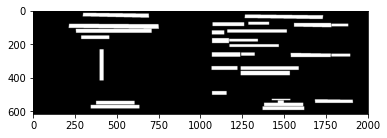

00018413_in.jpg


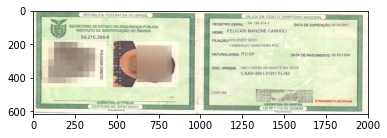

00018414_gt_ocr.txt
x, y, width, height, transcription
[329, 326, 725, 721], [16, 42, 42, 19], -1, -1, REPÚBLICA FEDERATIVA DO BRASIL
[236, 234, 775, 775], [83, 106, 107, 85], -1, -1, SECRETARIA DE ESTADO DA SEGURANÇA PÚBLICA
[276, 278, 738, 737], [111, 131, 134, 111], -1, -1, INSTITUTO DE IDENTIFICAÇÃO DO PARANÁ
347, 141, 137, 18, 08.071.995-8
[475, 473, 452, 457], [245, 428, 424, 244], -1, -1, POLEGAR DIREITO
[416, 415, 641, 641], [546, 561, 561, 546], -1, -1, ASSINATURA DO TITULAR
[385, 385, 666, 668], [566, 587, 588, 569], -1, -1, CARTEIRA DE IDENTIDADE
1221, 111, 398, 20, FUCHES MALULY PLENSACK
1221, 142, 98, 19, RAMOS
1235, 178, 252, 20, PRADOS SGOBI HAMACHI
1234, 217, 244, 14, HEISER PELLEGATTI BRICH
1305, 259, 148, 18, SETUBINHA-MG
[1126, 1128, 1280, 1280], [340, 364, 368, 341], -1, -1, DOC. ORIGEM
1305, 347, 443, 22, CMC= JARDIM DE ANGICOS-RN ,SEDE
1307, 378, 278, 16, C.NAS=449 LV=120 FL=201
1198, 440, 138, 15, 982.629.264-80
1128, 490, 116, 14, INHUMAS-GO
[1753, 1752, 1976, 1

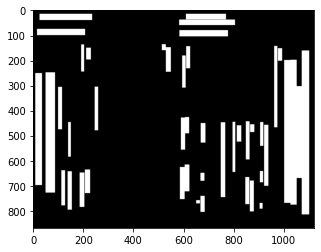

00000000_in.jpg


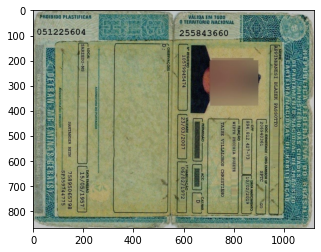

00000001_gt_ocr.txt
x, y, width, height, transcription
[117, 118, 625, 623], [22, 45, 41, 19], -1, -1, REPÚBLICA FEDERATIVA DO BRASIL
[225, 226, 510, 509], [46, 63, 60, 44], -1, -1, MINISTÉRIO DAS CIDADES
[146, 147, 592, 592], [65, 82, 79, 59], -1, -1, DEPARTAMENTO NACIONAL DE TRÂNSITO
[148, 147, 584, 584], [86, 101, 99, 81], -1, -1, CARTEIRA NACIONAL DE HABILITAÇÃO
109, 104, 37, 12, NOME
104, 120, 177, 9, PESSONI VALDILEI EMY
344, 146, 182, 13, DOC. IDENTIDADE/ÓRG EMISSOR UF
338, 163, 69, 11, 732213587
487, 163, 29, 8, SESP
583, 163, 18, 8, GO
343, 194, 22, 13, CPF
331, 209, 138, 12, 896.630.040-53
515, 194, 97, 11, DATA NASCIMENTO
498, 209, 103, 13, 14/05/1996
57, 277, 21, 173, 599905390
25, 272, 18, 186, O TERRITÓRIO NACIONAL
11, 302, 16, 125, VÁLIDA EM TODO
346, 236, 50, 16, FILIAÇÃO
338, 255, 197, 10, IONEDA MIYAKUCHI ZAV
337, 274, 57, 10, SANTOS
337, 294, 178, 10, FRAGA ADONIS CASAL
336, 313, 39, 10, LIMA
108, 411, 68, 13, Nº REGISTRO
135, 429, 106, 11, 07665700426
342, 356, 58, 

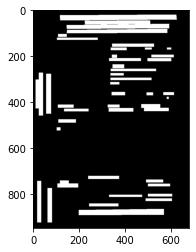

00000001_in.jpg


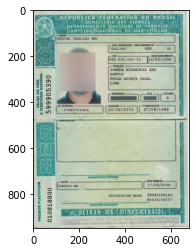

00000002_gt_ocr.txt
x, y, width, height, transcription
[117, 118, 625, 623], [22, 45, 41, 19], -1, -1, REPÚBLICA FEDERATIVA DO BRASIL
[225, 226, 510, 509], [46, 63, 60, 44], -1, -1, MINISTÉRIO DAS CIDADES
[146, 147, 592, 592], [65, 82, 79, 59], -1, -1, DEPARTAMENTO NACIONAL DE TRÂNSITO
[148, 147, 584, 584], [86, 101, 99, 81], -1, -1, CARTEIRA NACIONAL DE HABILITAÇÃO
109, 104, 37, 12, NOME
104, 120, 177, 9, PESSONI VALDILEI EMY
344, 146, 182, 13, DOC. IDENTIDADE/ÓRG EMISSOR UF
338, 163, 69, 11, 732213587
487, 163, 29, 8, SESP
583, 163, 18, 8, GO
343, 194, 22, 13, CPF
331, 209, 138, 12, 896.630.040-53
515, 194, 97, 11, DATA NASCIMENTO
498, 209, 103, 13, 14/05/1996
57, 277, 21, 173, 599905390
25, 272, 18, 186, O TERRITÓRIO NACIONAL
11, 302, 16, 125, VÁLIDA EM TODO
346, 236, 50, 16, FILIAÇÃO
338, 255, 197, 10, IONEDA MIYAKUCHI ZAV
337, 274, 57, 10, SANTOS
337, 294, 178, 10, FRAGA ADONIS CASAL
336, 313, 39, 10, LIMA
108, 411, 68, 13, Nº REGISTRO
135, 429, 106, 11, 07665700426
342, 356, 58, 

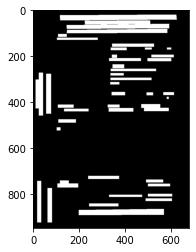

00000002_in.jpg


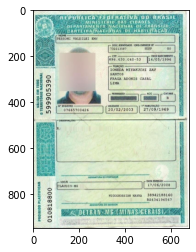

00000003_gt_ocr.txt
x, y, width, height, transcription
148, 129, 48, 14, NOME
138, 146, 251, 11, BOLZANI ANGHINONI ELTON
439, 178, 234, 12, DOC. IDENTIDADE/ÓRG EMISSOR UF
429, 196, 85, 11, 296989411
618, 196, 28, 10, SNJ
742, 194, 24, 12, GO
438, 234, 30, 13, CPF
425, 251, 149, 12, 474.458.483-71
654, 232, 121, 14, DATA NASCIMENTO
640, 250, 106, 13, 15/05/1967
442, 283, 63, 17, FILIAÇÃO
428, 305, 241, 11, YOSHIDA THIELLY PIERRO
429, 351, 208, 12, REATO LEPINE KNUDSE
428, 374, 83, 12, DA MATA
432, 424, 74, 18, PERMISSÃO
624, 426, 30, 14, ACC
714, 424, 61, 17, CAT. HAB.
728, 447, 12, 13, C
74, 334, 23, 184, 752999538
38, 312, 18, 222, O TERRITÓRIO NACIONAL
14, 347, 21, 153, VÁLIDA EM TODO
138, 489, 85, 14, Nº REGISTRO
173, 508, 128, 14, 33407763599
409, 488, 66, 16, VALIDADE
419, 506, 105, 16, 31/05/1983
591, 487, 104, 16, 1ª HABILITAÇÃO
608, 507, 125, 17, 19/02/1979
138, 565, 98, 17, OBSERVAÇÕES
284, 849, 172, 15, ASSINATURA DO PORTADOR
138, 881, 46, 16, LOCAL
122, 902, 143, 12, CANELIN

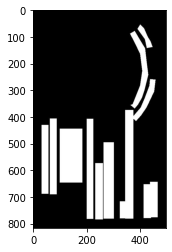

00010892_in.jpg


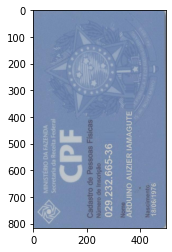

00010893_gt_ocr.txt
x, y, width, height, transcription
[108, 131, 105, 85, 63, 53, 26, 50, 70], [407, 429, 455, 493, 534, 574, 566, 508, 468], -1, -1, 15 DE NOVEMBRO
[122, 136, 111, 96, 85, 89, 117, 137, 119, 89, 72, 58, 75, 89, 102], [455, 476, 514, 555, 595, 642, 705, 748, 755, 706, 665, 612, 546, 504, 488], -1, -1, PÚBLICA FEDERATIVA DO BRASIL
[46, 67, 81, 104, 89, 63], [694, 688, 717, 768, 775, 725], -1, -1, DE 1889
458, 143, 21, 267, MINISTÉRIO DA FAZENDA
427, 142, 26, 290, SECRETARIA DA RECEITA FEDERAL
320, 189, 101, 198, CPF
281, 49, 29, 378, CADASTRO DE PESSOAS FÍSICAS
247, 47, 24, 212, NÚMERO DE INSCRIÇÃO
198, 47, 45, 333, 741.752.575-00
156, 50, 21, 64, NOME
116, 41, 29, 416, ZVEIBIL CLAGNAN CARREIRO
56, 49, 21, 137, NASCIMENTO
23, 45, 37, 196, 28/01/2016

00010893_gt_segmentation.jpg


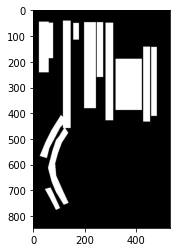

00010893_in.jpg


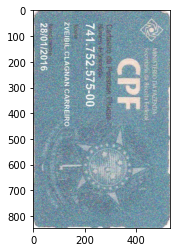

00010894_gt_ocr.txt
x, y, width, height, transcription
[491, 479, 544, 618, 664, 706, 743, 786, 773, 724, 642, 539], [380, 400, 436, 448, 447, 440, 425, 396, 379, 412, 431, 413], -1, -1, REPÚBLICA FEDERATIVA DO BRASIL
[435, 450, 478, 525, 593, 591, 515, 462, 450, 437], [402, 393, 416, 443, 463, 481, 459, 428, 420, 411], -1, -1, 15 DE NOVEMBRO
[796, 767, 731, 721, 714, 789], [428, 453, 465, 465, 449, 412], -1, -1, DE 1889
150, 50, 271, 24, MINISTÉRIO DA FAZENDA
151, 79, 296, 26, SECRETARIA DA RECEITA FEDERAL
193, 114, 212, 88, CPF
59, 212, 383, 29, CADASTRO DE PESSOAS FÍSICAS
56, 247, 218, 26, NÚMERO DE INSCRIÇÃO
53, 287, 274, 37, 844.868.401-00
57, 340, 65, 20, NOME
54, 356, 312, 30, BURATINI DIAZ GIOLO
59, 431, 127, 26, NASCIMENTO
58, 452, 142, 29, 11/02/1989

00010894_gt_segmentation.jpg


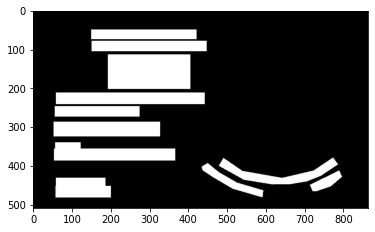

00010894_in.jpg


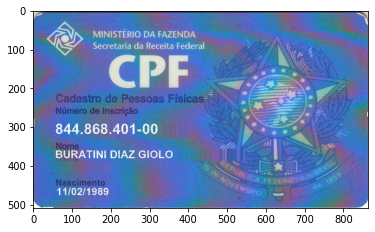

00010895_gt_ocr.txt
x, y, width, height, transcription
[232, 222, 201, 175, 136, 103, 73, 59, 51, 83, 126, 162, 192, 214], [74, 84, 69, 57, 52, 58, 75, 86, 73, 54, 40, 40, 50, 60], -1, -1, REPÚBLICA FEDERATIVA DO BRASIL
[259, 250, 241, 220, 191, 164, 166, 217, 241, 249], [70, 79, 69, 55, 40, 31, 19, 36, 53, 59], -1, -1, 15 DE NOVEMBRO
[92, 87, 69, 49, 41, 50, 72], [41, 30, 36, 49, 56, 63, 49], -1, -1, DE 1889
262, 278, 157, 15, MINISTÉRIO DA FAZENDA
250, 258, 170, 14, SECRETARIA DA RECEITA FEDERAL
275, 198, 125, 53, CPF
252, 176, 224, 17, CADASTRO DE PESSOAS FÍSICAS
351, 148, 128, 16, NÚMERO DE INSCRIÇÃO
255, 110, 207, 30, 637.168.284-91
441, 96, 38, 13, NOME
239, 69, 225, 25, RENNA DWECK DUCCI
405, 30, 73, 15, NASCIMENTO
302, 32, 89, 22, 06/04/1965

-----------------------------------
RG_FRENTE
00022188_gt_ocr.txt
x, y, width, height, transcription
82, 378, 31, 468, REPÚBLICA FEDERATIVA DO BRASIL
141, 377, 28, 454, ESTADO DE MINAS GERAIS
[177, 172, 202, 205], [314, 890, 890, 315], -1,

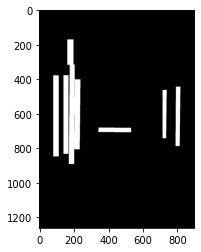

00022188_in.jpg


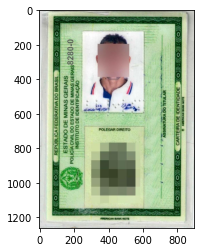

00022189_gt_ocr.txt
x, y, width, height, transcription
35, 281, 21, 307, REPÚBLICA FEDERATIVA DO BRASIL
[68, 73, 91, 86], [278, 584, 584, 278], -1, -1, ESTADO DE MINAS GERAIS
[95, 89, 108, 115], [622, 236, 236, 623], -1, -1, POLÍCIA CIVIL DO ESTADO DE MINAS GERAIS
[134, 129, 110, 115], [562, 297, 298, 562], -1, -1, INSTITUTO DE IDENTIFICAÇÃO
[199, 199, 331, 331], [489, 476, 474, 488], -1, -1, POLEGAR DIREITO
[459, 457, 471, 474], [516, 332, 332, 516], -1, -1, ASSINATURA DO TITULAR
[502, 498, 516, 519], [541, 313, 312, 540], -1, -1, CARTEIRA DE IDENTIDADE

00022189_gt_segmentation.jpg


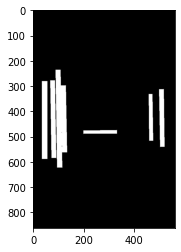

00022189_in.jpg


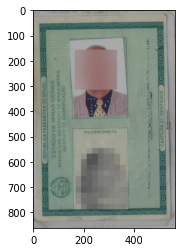

00022190_gt_ocr.txt
x, y, width, height, transcription
336, 60, 393, 22, REPÚBLICA FEDERATIVA DO BRASIL
379, 99, 285, 26, DISTRITO FEDERAL
307, 129, 429, 23, SECRETARIA DE SEGURANÇA PÚBLICA
443, 153, 157, 22, POLÍCIA CIVIL
322, 175, 399, 25, DPT - INSTITUTO DE IDENTIFICAÇÃO
452, 258, 20, 159, POLEGAR DIREITO
342, 470, 370, 32, MAIOR DE 65 ANOS
391, 608, 284, 22, CARTEIRA DE IDENTIDADE
408, 552, 232, 19, ASSINATURA DO TITULAR

00022190_gt_segmentation.jpg


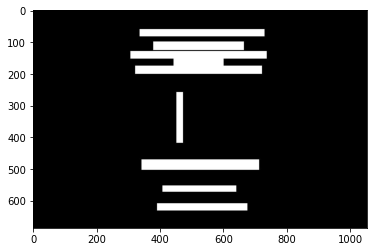

00022190_in.jpg


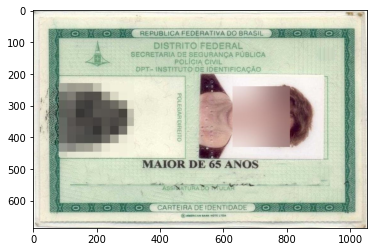

00022191_gt_ocr.txt
x, y, width, height, transcription
649, 301, 28, 365, REPÚBLICA FEDERATIVA DO BRASIL
610, 302, 26, 368, ESTADO DE MINAS GERAIS
582, 253, 20, 467, POLÍCIA CIVIL DO ESTADO DE MINAS GERAIS
556, 331, 25, 313, INSTITUTO DE IDENTIFICAÇÃO
298, 412, 171, 23, POLEGAR DIREITO
59, 345, 23, 269, CARTEIRA DE IDENTIDADE
[137, 121, 116, 132], [595, 594, 376, 381], -1, -1, ASSINATURA DO TITULAR

-----------------------------------
RG_VERSO
000111111_gt_ocr.txt
x, y, width, height, transcription
[50, 59, 41, 33], [596, 229, 229, 597], -1, -1, VÁLIDA EM TODO O TERRITÓRIO NACIONAL
74, 519, 18, 138, 08.096.661-5
141, 261, 20, 479, REBELO RONEI NAKAMURAKARE
[83, 86, 71, 73], [749, 681, 682, 750], -1, -1, REGISTRO
[99, 100, 88, 87], [749, 704, 704, 750], -1, -1, GERAL
[127, 129, 116, 115], [749, 707, 706, 750], -1, -1, NOME
[196, 198, 183, 182], [751, 688, 688, 751], -1, -1, FILIAÇÃO
206, 391, 18, 348, ADALTO CASCADAN FRASAO
240, 283, 20, 455, JANDHER SALLES GASPERAZZO
[305, 310, 297, 29

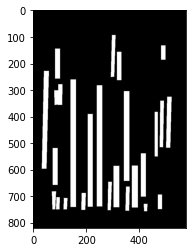

000111111_in.jpg


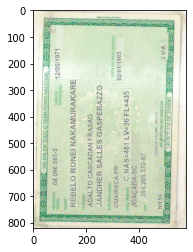

000230000_gt_ocr.txt
x, y, width, height, transcription
563, 466, 389, 22, KOHATSU LIBERATTI IVAN
566, 388, 389, 22, ADLER MAINO BENVENGA
461, 348, 495, 24, TOMAZINI RUIZ RHEINFRANCK
792, 269, 161, 23, CARMO-RJ
444, 229, 379, 23, C.NAS=59 LV=461 FL=372
658, 188, 297, 22, BREJO DO CRUZ-PB
691, 148, 210, 23, 188.354.397-52
867, 71, 84, 23, NH 85
155, 69, 77, 23, 9 VIA
187, 269, 149, 22, 05/05/1984
115, 291, 198, 16, DATA DE NASCIMENTO
196, 547, 141, 20, 19/06/2004
379, 543, 75, 16, DATA DE
353, 524, 103, 19, EXPEDIÇÃO
678, 546, 177, 22, 29.227.222-4
866, 544, 86, 16, REGISTRO
894, 525, 59, 16, GERAL
897, 489, 57, 17, NOME
872, 411, 82, 16, FILIAÇÃO
813, 293, 141, 17, NATURALIDADE
836, 214, 116, 16, DOC ORIGEM
917, 131, 34, 17, CPF
529, 78, 193, 16, JOLY FIERI YUKIU
415, 54, 225, 16, ASSINATURA DO DIRETOR
394, 18, 247, 21, LEI Nº7 116 DE 29/08/83
284, 574, 471, 21, VÁLIDA EM TODO O TERRITÓRIO NACIONAL

000230000_gt_segmentation.jpg


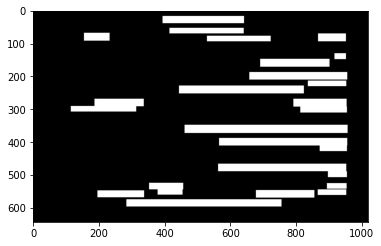

000230000_in.jpg


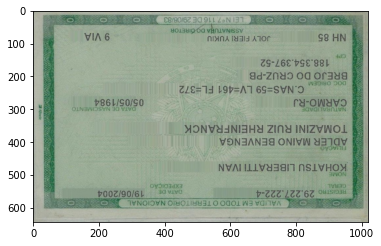

000233025_gt_ocr.txt
x, y, width, height, transcription
[229, 595, 595, 228], [77, 82, 66, 62], -1, -1, VÁLIDA EM TODO O TERRITÓRIO NACIONAL
146, 93, 114, 16, 73.377.624-3
[80, 146, 145, 80], [94, 95, 107, 107], -1, -1, REGISTRO
[80, 126, 125, 80], [122, 122, 111, 109], -1, -1, GERAL
[79, 120, 121, 79], [139, 139, 151, 151], -1, -1, NOME
62, 160, 272, 15, CHICARO OKUBARO SALVO
[78, 142, 141, 77], [203, 204, 219, 218], -1, -1, FILIAÇÃO
61, 225, 247, 15, RABAY PANTONI GIOSO
61, 258, 319, 20, AKIRA BARTELOTTI SHIMABUKO
77, 304, 108, 14, NATURALIDADE
77, 370, 92, 14, DOC ORIGEM
101, 421, 136, 15, 370.678.495-51
[76, 101, 102, 74], [452, 451, 438, 440], -1, -1, CPF
61, 487, 58, 15, NH 72
[313, 503, 503, 313], [543, 546, 527, 526], -1, -1, LEI Nº7 116 DE 29/08/83
250, 482, 225, 12, CONCILIO VALVERDE ANTZUK
[315, 487, 487, 315], [512, 514, 502, 501], -1, -1, ASSINATURA DO DIRETOR
622, 489, 48, 15, 7 VIA
61, 387, 208, 18, PROTÁSIO ALVES-RS
[576, 726, 727, 574], [309, 310, 323, 321], -1, -1, DA

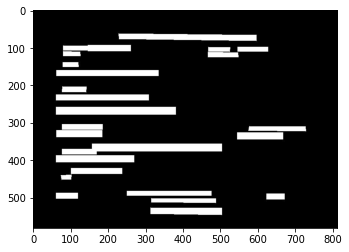

000233025_in.jpg


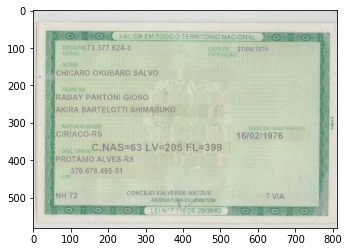

000233331_gt_ocr.txt
x, y, width, height, transcription
[281, 282, 756, 752], [54, 79, 73, 51], -1, -1, VÁLIDA EM TODO O TERRITÓRIO NACIONAL
214, 98, 132, 16, 84.941.430-1
[91, 176, 176, 92], [104, 104, 120, 120], -1, -1, REGISTRO
[91, 152, 149, 91], [138, 137, 121, 121], -1, -1, GERAL
[94, 146, 146, 93], [157, 158, 171, 172], -1, -1, NOME
117, 175, 378, 19, HOCHUN CERDEIRA CREMA
[96, 174, 173, 93], [235, 233, 250, 250], -1, -1, FILIAÇÃO
117, 256, 343, 18, NISHIMORI HERVAL MAURIZ
119, 293, 404, 19, FATARELLI LANCIA PODESTA
121, 374, 224, 18, SERINGUEIRAS-RO
[97, 232, 232, 97], [352, 351, 366, 365], -1, -1, NATURALIDADE
[733, 929, 928, 732], [362, 361, 344, 346], -1, -1, DATA DE NASCIMENTO
727, 370, 106, 16, 20/11/2008
248, 412, 279, 16, C.NAS=442 LV=62 FL=171
125, 452, 249, 16, ALFREDO WAGNER-SC
[101, 215, 215, 101], [446, 444, 430, 431], -1, -1, DOC ORIGEM
177, 492, 161, 16, 624.476.345-95
[102, 136, 136, 103], [510, 510, 524, 525], -1, -1, CPF
127, 570, 60, 16, NH 97
[412, 651, 650, 

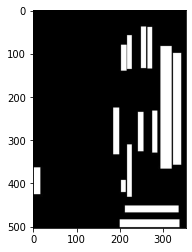

00007256_in.jpg


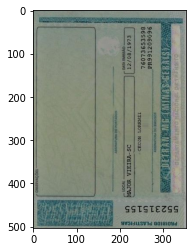

00007257_gt_ocr.txt
x, y, width, height, transcription
146, 9, 93, 16, OBSERVAÇÕES
299, 294, 166, 15, ASSINATURA DO PORTADOR
151, 324, 45, 13, LOCAL
137, 344, 140, 14, PALMÁCIA-CE
60, 334, 31, 200, 927563398
18, 318, 20, 206, PROIBIDO PLASTIFICAR
305, 435, 155, 15, ASSINATURA DO EMISSOR
393, 386, 149, 10, GERIBOLA VIGNOL
624, 322, 91, 14, DATA EMISSÃO
632, 342, 116, 16, 02/02/1971
629, 392, 139, 14, 27563740867
626, 418, 108, 11, AL253025310
245, 463, 466, 34, DETRAN - MG (MINAS GERAIS)

00007257_gt_segmentation.jpg


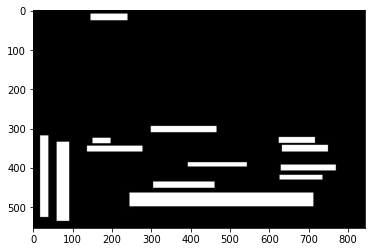

00007257_in.jpg


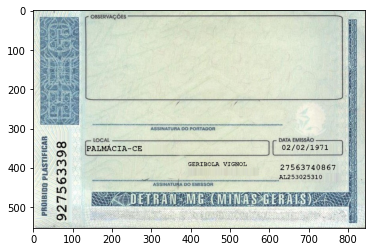

00007258_gt_ocr.txt
x, y, width, height, transcription
4, 473, 15, 80, OBSERVAÇÕES
22, 539, 16, 20, J;
249, 305, 14, 135, ASSINATURA DO PORTADOR
272, 513, 14, 37, LOCAL
294, 451, 10, 109, SALTINHO-SC
337, 212, 13, 111, NACARATTO ELYS J
276, 98, 13, 77, DATA EMISSÃO
293, 73, 17, 96, 01/02/1981
339, 63, 11, 108, 52286346119
359, 77, 15, 95, SC159585570
395, 119, 29, 369, DETRAN - MG (MINAS GERAIS)
370, 310, 14, 129, ASSINATURA DO EMISSOR
308, 601, 149, 19, 465655662
268, 645, 178, 19, PROIBIDO PLASTIFICAR

00007258_gt_segmentation.jpg


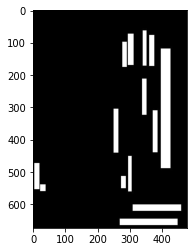

00007258_in.jpg


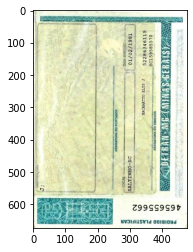

00007259_gt_ocr.txt
x, y, width, height, transcription
534, 153, 16, 95, OBSERVAÇÕES
252, 303, 13, 170, ASSINATURA DO PORTADOR
221, 159, 12, 46, LOCAL
202, 145, 11, 79, MAUÉS-AM
110, 310, 12, 157, ASSINATURA DO EMISSOR
154, 446, 9, 125, COL SCUDELER ROSSI
151, 638, 14, 118, 15541067652
130, 637, 12, 118, PB698220290
221, 634, 14, 93, DATA EMISSÃO
202, 641, 14, 106, 09/07/1981
62, 250, 33, 470, DETRAN - MG (MINAS GERAIS)
47, 74, 193, 24, 832318549
30, 24, 210, 20, PROIBIDO PLASTIFICAR

-----------------------------------
CNH_FRENTE
00003604_gt_ocr.txt
x, y, width, height, transcription
43, 445, 512, 22, REPÚBLICA FEDERATIVA DO BRASIL
154, 427, 289, 15, MINISTÉRIO DAS CIDADES
75, 409, 448, 18, DEPARTAMENTO NACIONAL DE TRÂNSITO
76, 386, 445, 19, CARTEIRA NACIONAL DE HABILITAÇÃO
520, 362, 38, 12, NOME
339, 349, 227, 10, FAVA STEFANELI KAWAHARA
138, 316, 187, 15, DOC. IDENTIDADE/ÓRG EMISSOR UF
160, 304, 22, 8, SES
69, 304, 15, 7, SP
262, 304, 68, 9, 912761751
300, 270, 27, 13, CPF
197, 258,

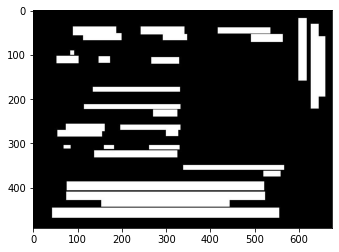

00003604_in.jpg


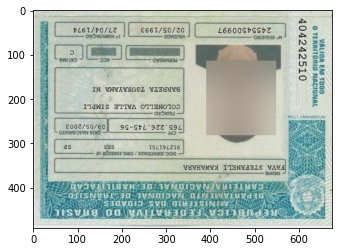

00003605_gt_ocr.txt
x, y, width, height, transcription
121, 6, 518, 28, REPÚBLICA FEDERATIVA DO BRASIL
227, 32, 305, 20, MINISTÉRIO DAS CIDADES
147, 51, 460, 18, DEPARTAMENTO NACIONAL DE TRÂNSITO
147, 68, 456, 22, CARTEIRA NACIONAL DE HABILITAÇÃO
120, 91, 43, 17, NOME
116, 112, 199, 10, GALIZIA EVELY ANOUCH
354, 140, 191, 15, DOC. IDENTIDADE/ÓRG EMISSOR UF
354, 155, 85, 11, 911290060
502, 159, 28, 9, POM
599, 158, 17, 10, SE
529, 189, 102, 17, DATA NASCIMENTO
357, 186, 25, 15, CPF
346, 204, 138, 11, 871.764.264-73
519, 204, 107, 15, 20/01/1963
359, 231, 57, 15, FILIAÇÃO
350, 252, 160, 9, EVIA STENEO ELIANE
347, 269, 66, 12, CASTRO
350, 288, 261, 11, BRIANEZE GLAESSNER BARRE
360, 307, 83, 12, BARBOSA
351, 349, 63, 15, PERMISSÃO
503, 353, 35, 15, ACC
579, 353, 45, 15, CAT. HAB.
595, 373, 7, 8, A
480, 404, 87, 15, 1ª HABILITAÇÃO
495, 420, 125, 16, 18/04/2002
334, 406, 57, 12, VALIDADE
336, 420, 106, 14, 14/08/2017
117, 399, 71, 16, Nº REGISTRO
141, 417, 107, 12, 10050552473
58, 288, 19, 1

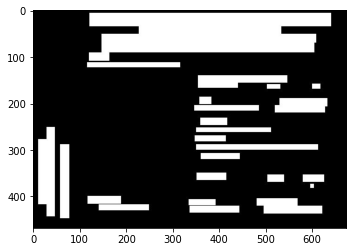

00003605_in.jpg


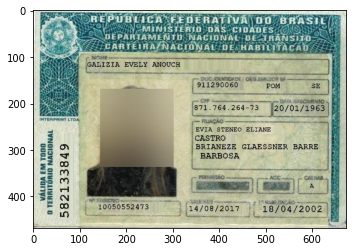

00003606_gt_ocr.txt
x, y, width, height, transcription
14, 56, 29, 649, REPÚBLICA FEDERATIVA DO BRA
41, 203, 18, 364, MINISTÉRIO DAS CIDADES
61, 105, 18, 561, DEPARTAMENTO NACIONAL DE TRÂNSITO
84, 109, 23, 552, CARTEIRA NACIONAL DE HABILITAÇÃO
122, 647, 11, 53, NOME
136, 469, 12, 237, LOIZE MARCUNS GEISON
167, 168, 18, 238, DOC. IDENTIDADE/ÓRG EMISSOR UF
188, 90, 8, 16, PR
187, 186, 12, 43, SESP
187, 326, 11, 87, 573051720
223, 373, 16, 35, CPF
240, 269, 14, 149, 345.021.995-24
222, 71, 16, 125, DATA NASCIMENTO
238, 96, 16, 108, 05/05/1963
272, 336, 19, 69, FILIAÇÃO
296, 158, 10, 256, BROCHADO GLEUSON CAPELOSSI
319, 343, 10, 69, BARBOSA
339, 161, 12, 249, SEGEREN OTANI MOISEIS
416, 331, 15, 78, PERMISSÃO
412, 179, 17, 42, ACC
409, 63, 21, 64, CAT. HAB.
434, 92, 11, 20, AB
474, 140, 22, 110, 1ª HABILITAÇÃO
490, 114, 20, 116, 25/03/2017
479, 359, 15, 74, VALIDADE
490, 314, 19, 107, 13/11/1997
478, 612, 17, 89, Nº REGISTRO
497, 550, 13, 118, 43803796166
341, 746, 205, 25, 711562086
332, 8

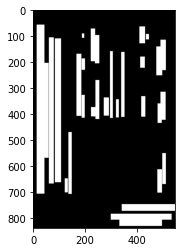

00003606_in.jpg


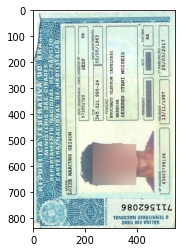

00003607_gt_ocr.txt
x, y, width, height, transcription
636, 428, 49, 13, NOME
157, 381, 236, 15, DOC. IDENTIDADE/ÓRG EMISSOR UF
187, 368, 28, 10, SEJ
75, 369, 19, 10, CE
313, 365, 87, 12, 133928524
358, 324, 39, 16, CPF
227, 307, 178, 16, 643.305.100-65
56, 325, 126, 18, DATA NASCIMENTO
82, 305, 108, 19, 03/04/2015
322, 273, 67, 17, FILIAÇÃO
196, 255, 204, 13, FRY ABATE RICCIARDI
337, 231, 63, 13, SOUZA
118, 211, 282, 12, IWAZAKI MAZZIOTTI ROSEMARY
333, 189, 69, 10, ALMEIDA
322, 129, 76, 20, PERMISSÃO
173, 133, 34, 16, ACC
57, 132, 57, 17, CAT. HAB.
79, 118, 20, 11, AB
131, 71, 110, 17, 1ª HABILITAÇÃO
115, 54, 108, 15, 01/06/1989
351, 68, 69, 15, VALIDADE
307, 53, 109, 14, 04/04/1969
540, 51, 118, 13, 20310278095
605, 64, 91, 18, Nº REGISTRO
741, 35, 23, 184, 491818040
797, 53, 23, 158, VÁLIDA EM TODO
775, 11, 21, 235, O TERRITÓRIO NACIONAL
[685, 47, 47, 685], [534, 546, 519, 508], -1, -1, REPÚBLICA FEDERATIVA DO BRASIL
[546, 185, 185, 546], [507, 514, 494, 488], -1, -1, MINISTÉRIO DAS

In [ ]:
#display the first few elements in each folder to get a sense of what they are

folder_path = '/content/BID Dataset'

first_n = 10

for folder_name in os.listdir(folder_path):
    folder = os.path.join(folder_path, folder_name)
    if not os.path.isdir(folder):
        continue

    print(folder_name.upper())
    
    img_names = os.listdir(folder)
    # sort to see each image and its labels
    img_names = sorted(img_names)
    for img_name in img_names[0:first_n]:
        print(img_name)
        img_path = os.path.join(folder, img_name)

        if img_path.endswith('.txt'):
            #read to see if it has the boxes
            file_ = open(img_path, encoding='latin-1')
            txt = file_.read()
            file_.close()

            print(txt)

        if not img_path.endswith('.jpg'):
            continue
        # img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        img = read_image(img_path)

        plt.figure()
        plt.imshow(img)
        plt.show()

    print('-----------------------------------')



> we are going to deal with the 'CNH_FRENTE' folder (CNH front face) and treat this as a text detection problem

In [27]:
# get the image ids from the folder
data_folder = '/content/BID Dataset/CNH_Frente'
img_ids = [item.split('_')[0] for item in os.listdir(data_folder)]
img_ids[0:10]

['00004726',
 '00006351',
 '00003818',
 '00005793',
 '00007106',
 '00006345',
 '00004741',
 '00006482',
 '00007120',
 '00004736']

# 3. Dataset Class

In [33]:
chars = range('a', 'z')

TypeError: ignored

In [48]:
class IDImageDataset(torch.utils.data.Dataset):

  def __init__(self, dir, id_list, width, height, transforms=None):
    self.dir = dir
    self.id_list = id_list
    self.width = width
    self.height = height
    self.transforms = transforms

    self.image_names = [item+'_in.jpg' for item in id_list]
    self.label_names = [item+'_gt_ocr.txt' for item in id_list]



  def __getitem__(self, index):
    
    # loads img, change it to rgb, resizes it, normalize it
    c = 0
    img_name = self.image_names[index]
    img_path = os.path.join(self.dir, img_name)

    orig_img = cv2.imread(img_path)
    img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
    img /= 255.0

    # load annotation file, extract labels from it

    annot_file_name = self.label_names[index]
    annot_file_path = os.path.join(self.dir, annot_file_name)

    boxes = []
    labels = []

    with open(annot_file_path, encoding='latin-1') as f:
      for i, line in enumerate(f):
        if i == 0:
            continue
        labels.append(1)


        # print(line)
        # sometimes it is nested
        if '[' in line:
            c += 1
            continue #ignore them for now
        
        # line.replace('[', '').replace(']', '')

        box_coords = [np.float(item) for item in line.split(',')[0:4]]
        # need to normalize the box coords then multiply by output image size (224, 224)

        #x, y, width, height
        x, y, width, height = box_coords[0], box_coords[1], box_coords[2], box_coords[3]
        xmin, ymin, xmax, ymax = x, y, x+height, y+width

        boxes.append([xmin, ymin, xmax, ymax])

      # change to tensors
      boxes = torch.as_tensor(boxes, dtype=torch.int64)

      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

      iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)

      labels = torch.as_tensor(labels, dtype=torch.int64)

      target = {}

      target['boxes'] = boxes
      target['labels'] = labels
      target['area'] = area
      target['iscrowd'] = iscrowd
      target['image_id'] = torch.tensor([index])
      # print(target)
      if self.transforms:
        sample = self.transforms(image = img, bboxes=target['boxes'], labels = labels)
        img = sample['image']
        target['boxes'] = torch.Tensor(sample['bboxes'])
    
    #   print(c)
      return img, target

  def __len__(self):
    return len(self.image_names)



In [49]:
dataset = IDImageDataset(data_folder, img_ids, 224, 224)
# check that it works
print('len of dataset: ', len(dataset))
# pick an (x, y)
img, target = dataset[3]
print(img.shape)
print(target)


len of dataset:  10800
(224, 224, 3)
{'boxes': tensor([[  54,  509,   86, 1179],
        [ 197,  491,  218,  877],
        [  95,  465,  124, 1052],
        [  96,  447,  115, 1033],
        [ 670,  429,  688,  476],
        [ 488,  415,  498,  654],
        [ 167,  375,  187,  622],
        [ 329,  360,  341,  455],
        [ 196,  359,  208,  391],
        [  81,  358,   93,  378],
        [ 380,  316,  400,  350],
        [ 233,  303,  248,  494],
        [  63,  318,   79,  451],
        [  78,  300,   94,  427],
        [ 343,  267,  360,  334],
        [ 158,  247,  172,  509],
        [ 356,  225,  367,  290],
        [ 149,  201,  162,  471],
        [ 343,  180,  355,  257],
        [ 335,  122,  353,  205],
        [ 180,  122,  195,  162],
        [  62,  123,   79,  184],
        [  99,  105,  110,  116],
        [ 138,   58,  157,  169],
        [ 119,   40,  134,  157],
        [ 369,   61,  386,  131],
        [ 306,   42,  322,  168],
        [ 630,   61,  647,  149],
 

In [55]:
# visualize dataset example
def plot_sample(img, target):
  fig, ax = plt.subplots(1,1)
  
  ax.imshow(img)

  print(len(target['boxes']))
  for box in target['boxes']:
    box = box.to('cpu') # patches won't work with GPU tensors
    x, y, w, h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor = 'r', facecolor='none')
    ax.add_patch(rect)

  plt.show()

32


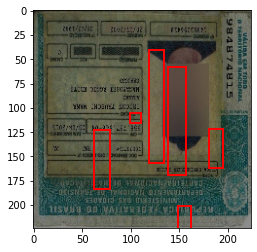

In [56]:
img, target = dataset[3]
plot_sample(img, target)

# Data Augmentation
using albumentations

In [ ]:
def get_transform(train):
  if train:
    return A.Compose([A.HorizontalFlip(0.5), ToTensorV2(p=1.0)], 
                     bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']})
    
  else:
    return A.Compose([ToTensorV2(p=1.0)],
                     bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    

# DataLoaders

In [ ]:
# split data

In [ ]:
train_dataset = ConeImageDataset(train_dir, 720, 720, transforms=get_transform(train=True))
test_dataset = ConeImageDataset(test_dir, 720, 720, transforms=get_transform(train=False))


In [ ]:
# split train into train and val datasets

indices = torch.randperm(len(dataset)).tolist()
test_split = 0.2
test_size = int(len(dataset)*test_split)

train_ds = torch.utils.data.Subset(train_dataset, indices[:-test_size])
val_ds = torch.utils.data.Subset(train_dataset, indices[-test_size:])

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
test_data_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

# Load Pre-trained Model

In [ ]:
def get_object_detection_model(num_classes):
  # pretrained on coco dataset
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # replace the pretrained head with anew one that has the num_classes
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model


# Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

model = get_object_detection_model(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  
  train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)

  lr_sched.step()

  evaluate(model, test_data_loader, device=device)

Epoch: [0]  [0/7]  eta: 0:00:34  lr: 0.000837  loss: 1.0607 (1.0607)  loss_classifier: 0.6366 (0.6366)  loss_box_reg: 0.3266 (0.3266)  loss_objectness: 0.0782 (0.0782)  loss_rpn_box_reg: 0.0192 (0.0192)  time: 4.9438  data: 2.1426  max mem: 11778
Epoch: [0]  [6/7]  eta: 0:00:02  lr: 0.005000  loss: 0.7310 (0.8051)  loss_classifier: 0.2816 (0.3735)  loss_box_reg: 0.3444 (0.3272)  loss_objectness: 0.0555 (0.0826)  loss_rpn_box_reg: 0.0192 (0.0219)  time: 2.9012  data: 0.3547  max mem: 11778
Epoch: [0] Total time: 0:00:20 (2.9205 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:04  model_time: 1.2076 (1.2076)  evaluator_time: 0.0265 (0.0265)  time: 2.1118  data: 0.8466  max mem: 11778
Test:  [1/2]  eta: 0:00:01  model_time: 0.6583 (0.9330)  evaluator_time: 0.0186 (0.0225)  time: 1.4098  data: 0.4307  max mem: 11778
Test: Total time: 0:00:02 (1.4736 s / it)
Averaged stats: model_time: 0.6583 (0.9330)  evaluator_time: 0.0186 (0.0225)
Accumulating evaluation results...
DONE (

# non-max supression

In [ ]:
def apply_nms(prediction, iou_thresh=0.3):
  keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], iou_thresh)

  # print(keep)
  prediction['boxes'] = prediction['boxes'][keep]
  prediction['scores'] = prediction['scores'][keep]
  prediction['labels'] = prediction['labels'][keep]

  return prediction

def torch_tensor_to_pil_img(tensor):
  return torchtrans.ToPILImage()(tensor).convert('RGB')



# Testing

In [ ]:
# visualize dataset example
def plot_test_sample(img, pred, conf_thresh=0.6):
  fig, ax = plt.subplots(1,1)
  
  ax.imshow(img)
  for box, score in zip(pred['boxes'], pred['scores']):
    box = box.to('cpu') # patches won't work with GPU tensors
    score = np.round(score.to('cpu').item(), 2)

    if score > conf_thresh:
      x, y, w, h = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor = 'r', facecolor='none')
      ax.text(x, y, str(score), fontsize=8, fontweight='bold')
      ax.add_patch(rect)

  plt.show()

In [ ]:
len(test_dataset)

38

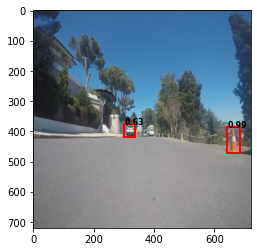

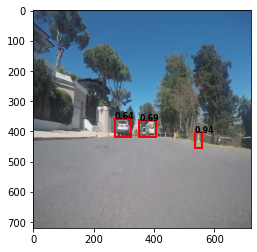

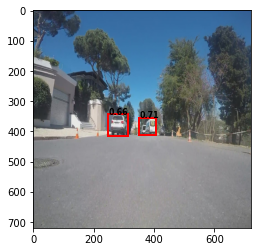

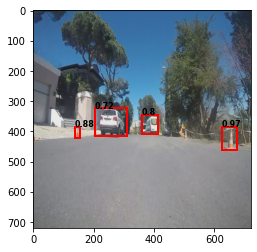

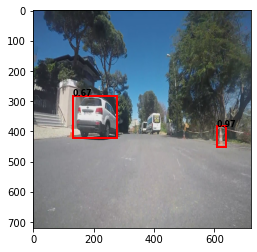

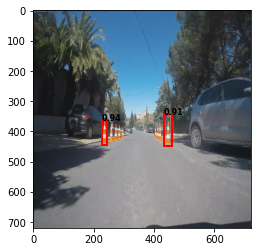

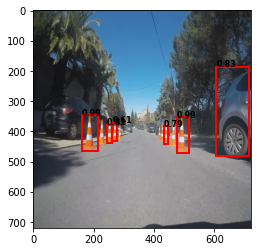

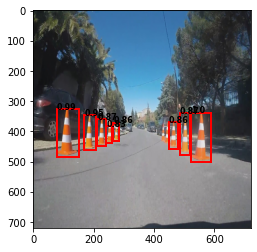

8
9


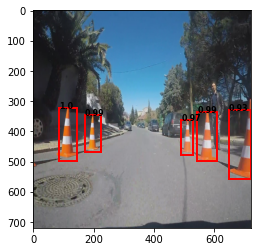

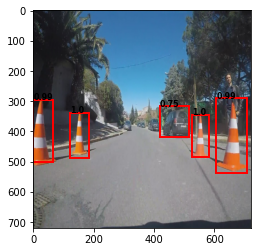

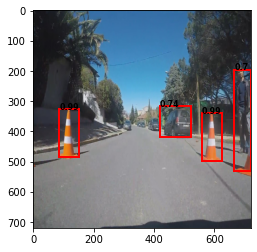

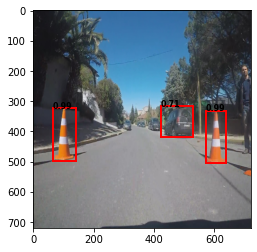

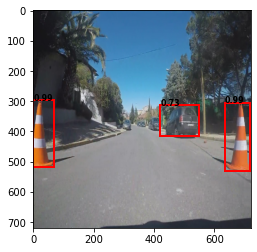

15


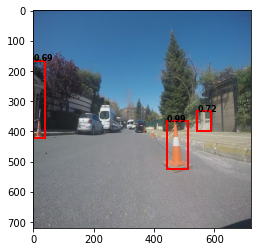

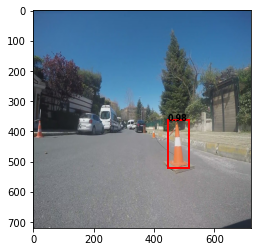

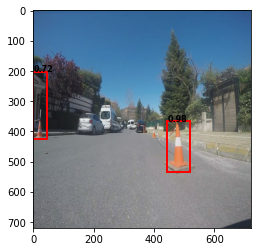

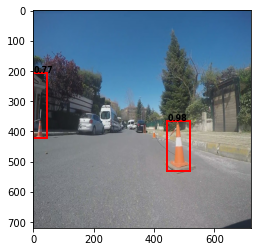

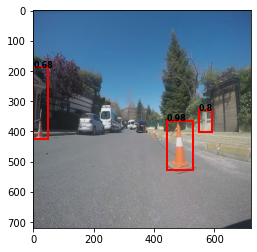

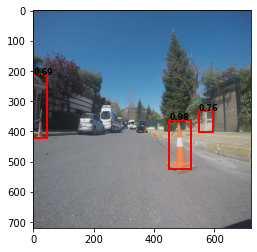

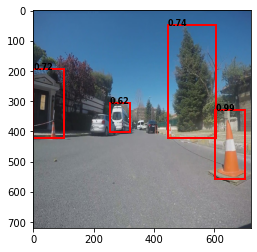

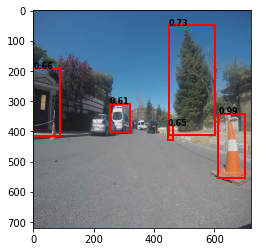

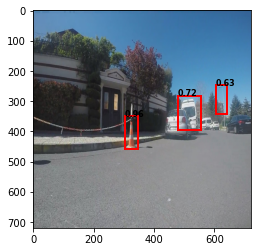

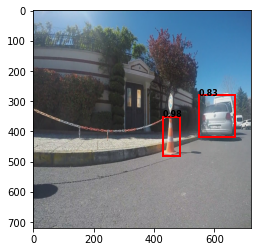

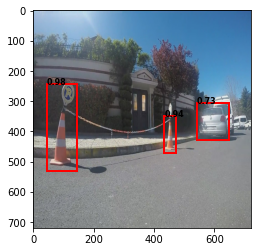

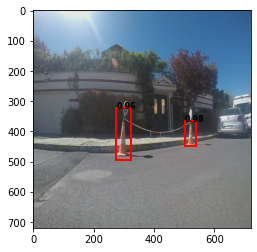

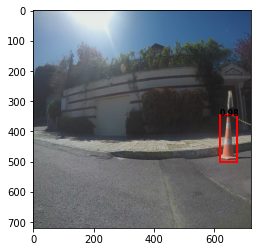

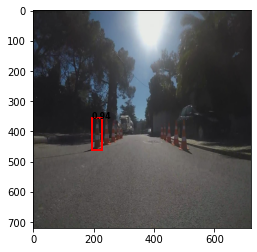

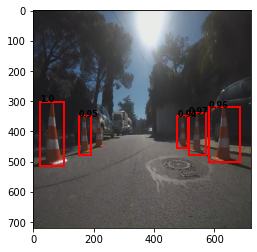

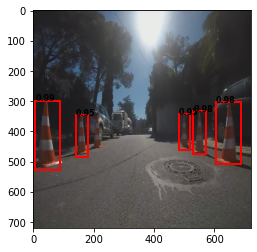

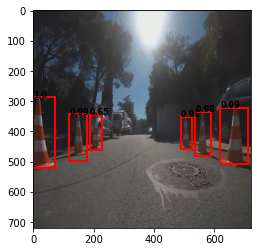

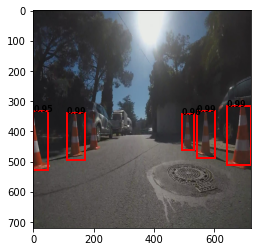

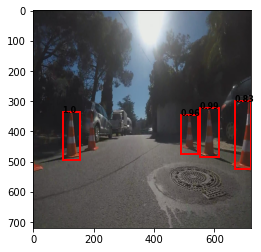

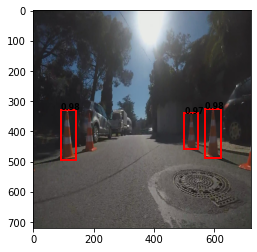

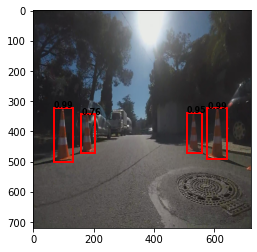

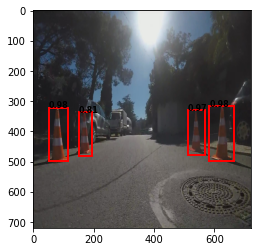

In [ ]:

for i in range(len(test_dataset)):
  try:
    img, target = test_dataset[i]
    # continue
  except:
    print(i)
    continue
  model.eval()
  with torch.no_grad():
    pred = model([img.to(device)])

  # print(pred)
  nms_pred = apply_nms(pred[0], iou_thresh=0.01)
  # print(nms_pred)
  plot_test_sample(torch_tensor_to_pil_img(img), nms_pred)

In [ ]:
# test_set_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)
# evaluate(model, test_set_data_loader, device=device)